# Hand Gesture Detection
### Ángela Mejía García - T00058563
### Jaider Chico Navarro - T00058479 


---
### Captura de imagenes

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Hands_Trial_v3/Hands_Dataset' # Ubicacion de mis imagenes iniciales
outpath = '/content/drive/MyDrive/Hands_Trial_v3/Hands_Pre_tv3' # Ubicacion de las imagenes pre-procesadas
maskpath = '/content/drive/MyDrive/Hands_Trial_v3/Hands_Mask_tv3' # Ubicación de las mask

In [3]:
# Se importan librerias
import os
import cv2 as cv
from google.colab.patches import cv2_imshow 
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import pandas as pd

Para determinar el mejor filtro a usar para el pre-procesamiento de la imagen, se experimentará con distintos filtros en una misma imagen, considerando que las imagenes fueron capturadas de manera que las condiciones sean aproximadamente iguales para cada una.


In [4]:
img = cv.imread('/content/drive/MyDrive/Hands_Trial_v3/Hands_Dataset/Palma_W1.jpg') # Se define la imagen a trabajar
np.shape(img) # Tamaño de las imagenes capturadas

(1201, 959, 3)

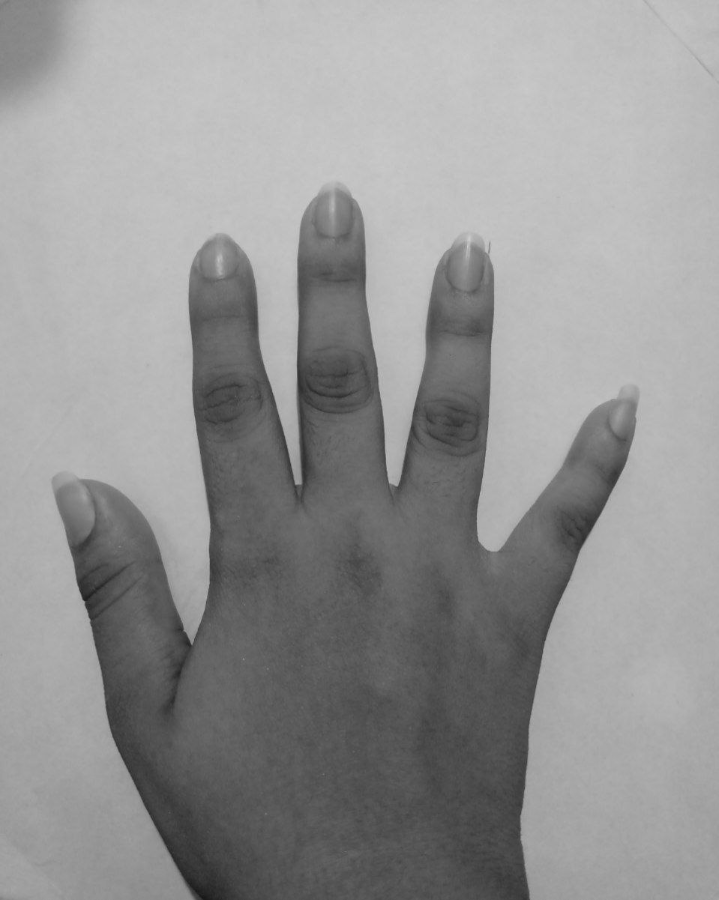

(900, 719)

In [5]:
# Se transforma la imagen a escala de grises
img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Se disminuye el tamaño de la imagen un 25%
new_size = (int(img_g.shape[1] * 0.75), int(img_g.shape[0] * 0.75))
rimg = cv.resize(img_g, new_size)
cv2_imshow(rimg)
np.shape(rimg)

#### Averaging or Box Filter

<function matplotlib.pyplot.show(close=None, block=None)>

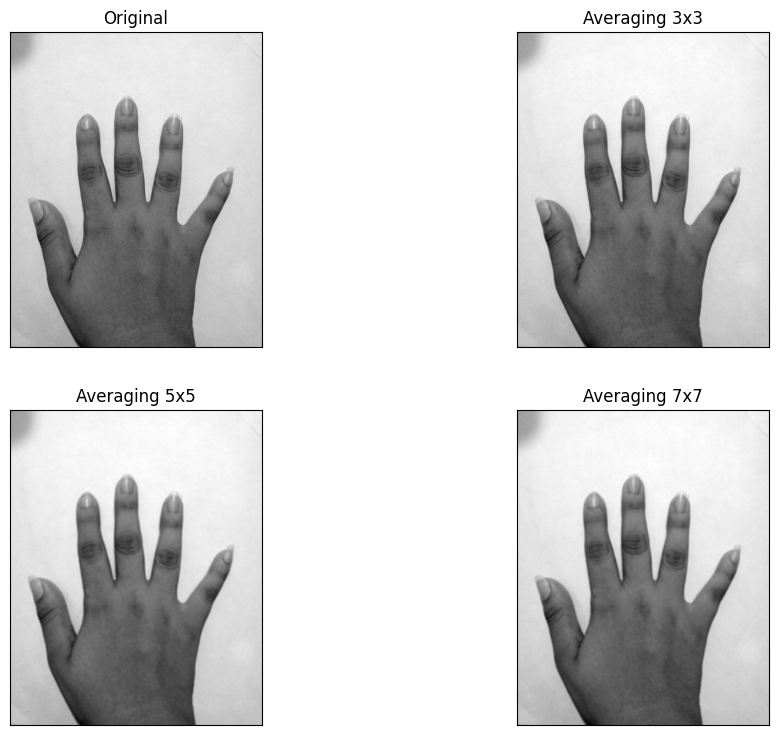

In [6]:
# Kernel 3x3
k1 = np.ones((3,3), np.float32)/9
dst = cv.filter2D(rimg,-1,k1)
# Kernel 5x5
k2 = np.ones((5,5), np.float32)/25
dst2 = cv.filter2D(rimg,-1,k2)
# Kernel 7x7
k3 = np.ones((7,7), np.float32)/49
dst3 = cv.filter2D(rimg,-1,k2)

plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(img_g, cmap = 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(dst, cmap = 'gray')
plt.title('Averaging 3x3')
plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(dst2, cmap = 'gray')
plt.title('Averaging 5x5')
plt.xticks([]), plt.yticks([])
plt.subplot(224)
plt.imshow(dst3, cmap = 'gray')
plt.title('Averaging 7x7')
plt.xticks([]), plt.yticks([])
plt.show

A partir de lo mencionado, el kernel 3x3 ofrece un mejor resultado, al garantizar que los bordes de la imagen se respeten de mejor manera

#### Gaussian Filter

<function matplotlib.pyplot.show(close=None, block=None)>

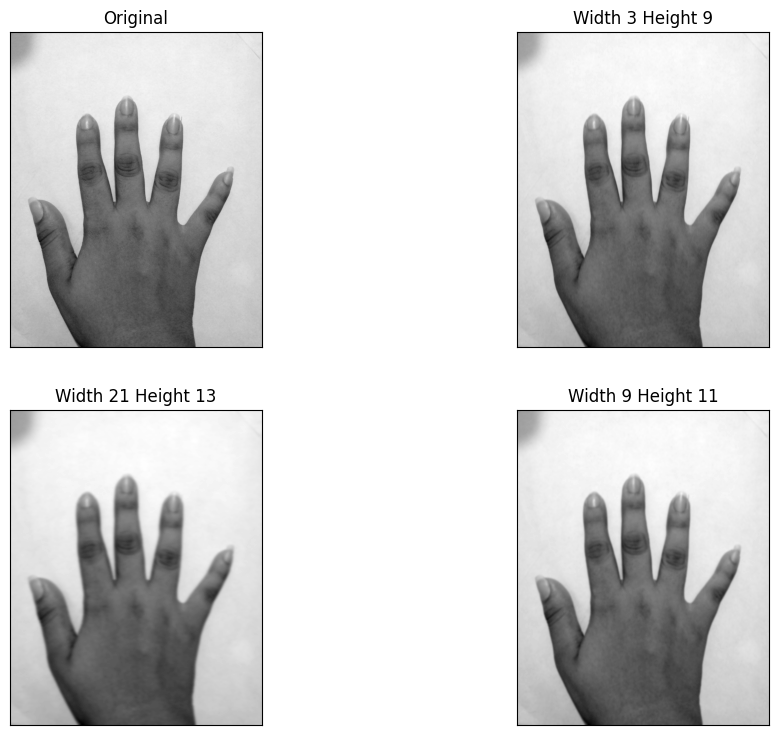

In [7]:
# Width 3 Height 9
gau = cv.GaussianBlur(rimg,(3,9),0)
# Width 21 Height 13
gau2 = cv.GaussianBlur(rimg,(21,13),0)
# Width 9 Height 11 
gau3 = cv.GaussianBlur(rimg,(9,11),0)

plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(rimg, cmap = 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(gau, cmap = 'gray')
plt.title('Width 3 Height 9')
plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(gau2, cmap = 'gray')
plt.title('Width 21 Height 13')
plt.xticks([]), plt.yticks([])
plt.subplot(224)
plt.imshow(gau3, cmap = 'gray')
plt.title('Width 9 Height 11')
plt.xticks([]), plt.yticks([])
plt.show

Para la elección de la mejor forma de pre-procesar las imagenes se tiene:

<function matplotlib.pyplot.show(close=None, block=None)>

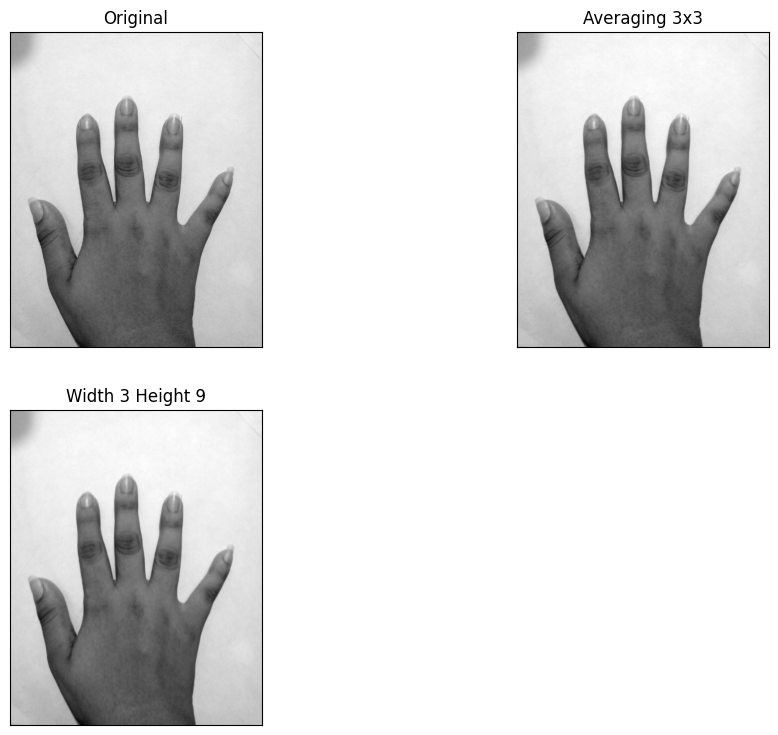

In [8]:
plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(rimg, cmap = 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(dst, cmap = 'gray')
plt.title('Averaging 3x3')
plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(gau, cmap = 'gray')
plt.title('Width 3 Height 9')
plt.xticks([]), plt.yticks([])
plt.show

Por lo anterior, se toma la imagen a la que se le ha aplicado el filtro gaussiano.

---
### Pre-procesamiento

Se define una función que realice todo el pre-procesamiento de las imagenes alojadas en el folder

In [9]:
target_size= (900,1200)
def preprocessing(input, output):
    # Recorre todas las imagenes del folder
    for filename in os.listdir(input):
        # Lee la imagen
        image_path = os.path.join(input, filename)
        img = cv.imread(image_path)
        # Actividades de pre-procesamiento
        img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Se cambia el tamaño para obtener imagenes homogeneas
        rimg = cv.resize(img_g, target_size)
        # Se aplica el filtro gaussiano width 3 height 9
        gau = cv.GaussianBlur(rimg,(3,9),0)
        # Se guarda la imagen procesada en el folder
        output_path = os.path.join(output, filename)
        cv.imwrite(output_path, gau)
    print('Se han procesado todas las imagenes')

preprocessing(path, outpath)


Se han procesado todas las imagenes


---
### Hand Detection and Segmentation

Defino una imagen de prueba para la conversión a imagenes binarias para la segmentación de la mano


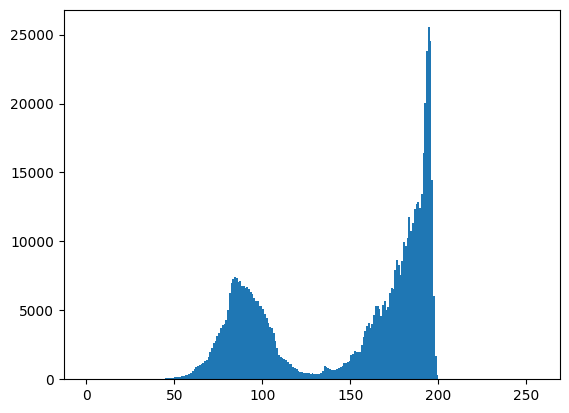

In [10]:
# Se mantiene la misma imagen que se desarrollo de muestra 
plt.hist(gau.ravel(),bins = 256, range = [0,256])
plt.show()

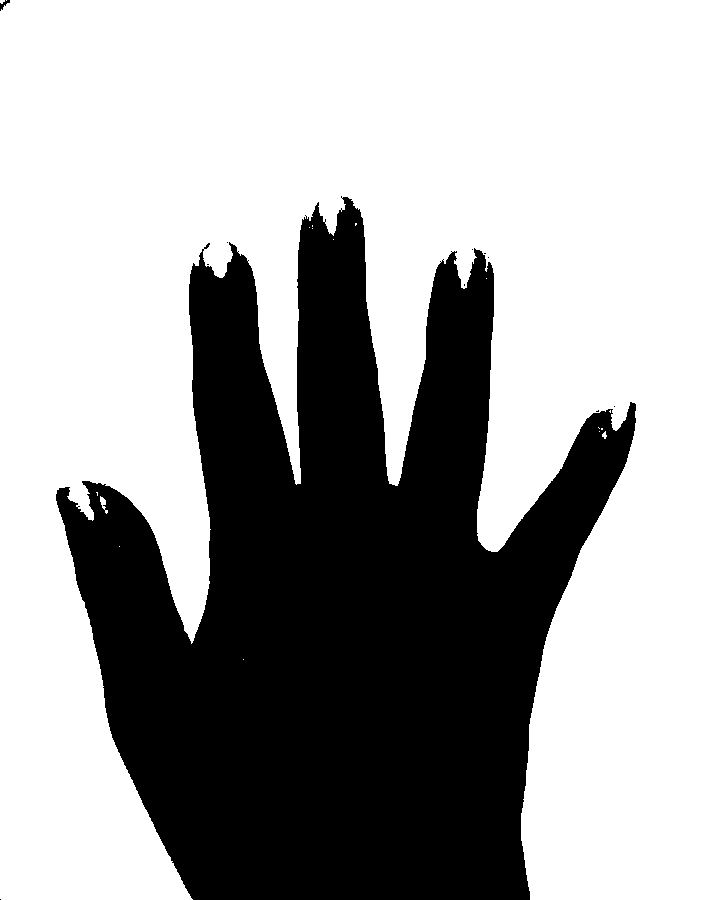

In [11]:
# Considerando como umbral el valor medio en el histograma de la imagen
mask = np.zeros(rimg.shape, dtype=np.uint8)
mask[rimg >= 130] = 255
cv2_imshow(mask)

Se contempla a su vez la normalización del histograma para la obtención de mascarás más precisas

*Normalización del histograma*

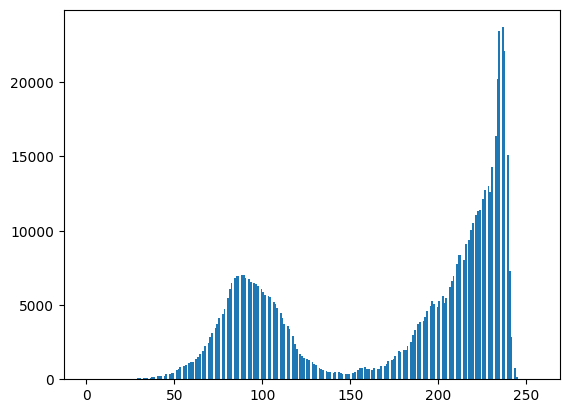

In [12]:
hist = rimg.ravel()
# Se normalizan los valores del histograma a un rango de 0 a 255
normalized_hist = cv.normalize(hist, None, 0, 255, cv.NORM_MINMAX)
plt.hist(normalized_hist.ravel(),bins = 256, range = [0,256]) 
plt.show()

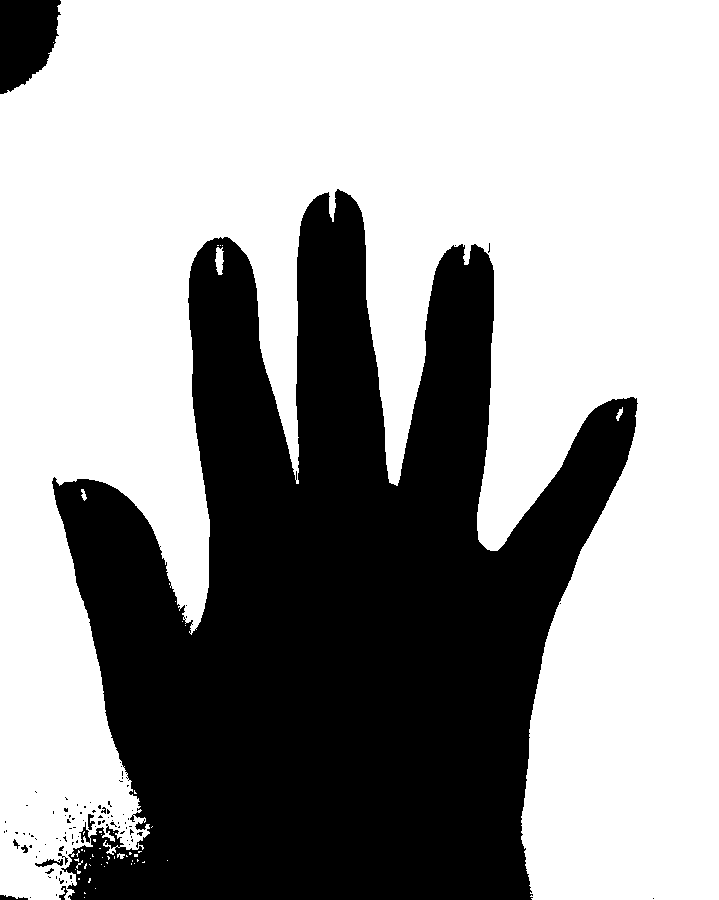

In [13]:
hand_threshold_value = 150  # Adjust this value based on your image
_, hand_binary_image = cv.threshold(rimg, hand_threshold_value, 255, cv.THRESH_BINARY)
cv2_imshow(hand_binary_image)


Se contempla a su vez, el uso de contornos para definir la mascara de la mano. 

*Umbralización y selección de contornos*

<function matplotlib.pyplot.show(close=None, block=None)>

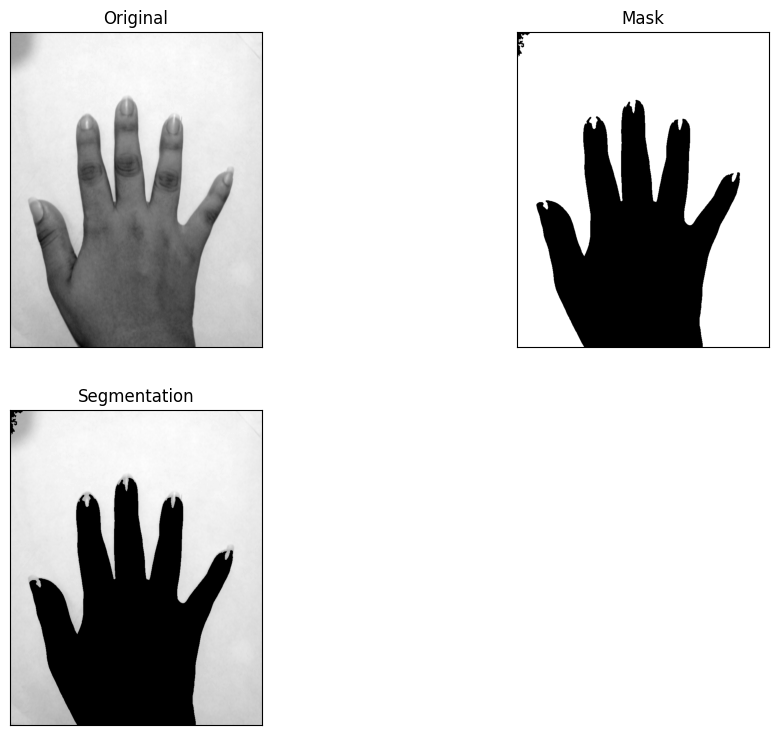

In [14]:
# Se umbraliza la imagen
_, thresh = cv.threshold(gau, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# Se buscan los contornos
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# Selecciona el contorno más largo
hand_contour = max(contours, key=cv.contourArea)
# Se crea la mask para la mano
maskt = np.zeros_like(gau)
cv.drawContours(maskt, [hand_contour], 0, (255, 255, 255), -1)
# Se aplica la mascara a la imagen original
hand_img = cv.bitwise_and(gau, gau, mask=maskt)
plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(gau, cmap = 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(maskt, cmap = 'gray')
plt.title('Mask')
plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(hand_img, cmap = 'gray')
plt.title('Segmentation')
plt.xticks([]), plt.yticks([])
plt.show



**Definición de la segmentación**

Finalmente, se comparan todos los resultados obtenidos para la elección del metodo a usar para la obtención de la mascara de la imagen.

<function matplotlib.pyplot.show(close=None, block=None)>

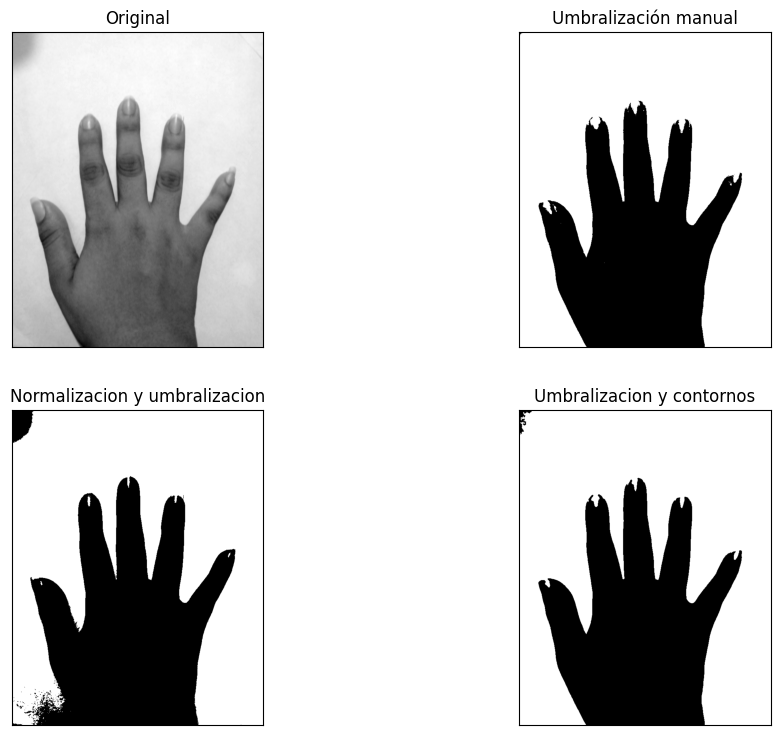

In [15]:
plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(gau, cmap = 'gray')
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(mask, cmap = 'gray')
plt.title('Umbralización manual')
plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(hand_binary_image, cmap = 'gray')
plt.title('Normalizacion y umbralizacion')
plt.xticks([]), plt.yticks([])
plt.subplot(224)
plt.imshow(maskt, cmap = 'gray')
plt.title('Umbralizacion y contornos')
plt.xticks([]), plt.yticks([])
plt.show

Se puede observar que los mejores resultados parecen ser obtenidos de forma manual, sin embargo, este valor puede variar de imagen a imagen debido a las condiciones de luz, tono de piel de la mano y porcentaje de piel vs fondo, por lo que lo mejor es usar una herramienta de umbralización automatica como cv.THRESH_BINARY+cv.THRESH_OTSU

Por otro lado, se considera la aplicación de operaciones morfologicas para permitir que los orificios de la imagen se rellenen (como los generados por el contraste del color de las uñas frente a la demas pigmentación de la mano) y demás ruido. 

Se utiliza un kernel de gran tamaño para rellenar los orificios. 

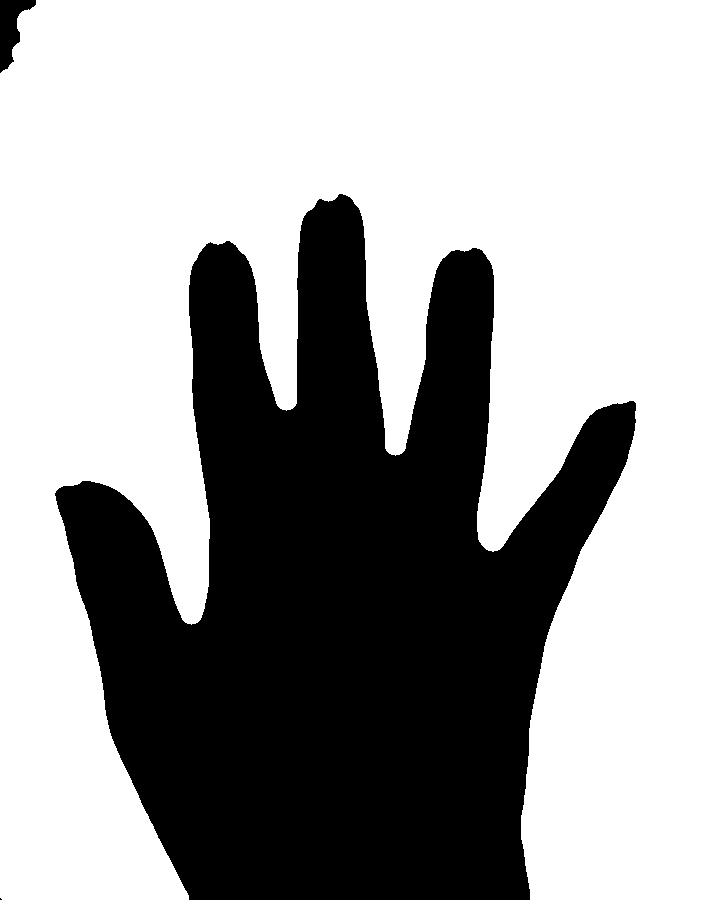

In [16]:
# Aplicación de operaciones morfologicas
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (21, 21))
segmented_image = cv.morphologyEx(maskt, cv.MORPH_OPEN, kernel)

# Se desarrolla un analisis de componentes para la identificación de las regiones conectadas
_, labels, stats, _ = cv.connectedComponentsWithStats(segmented_image)

# Se procura el indice del componente más largo, la mano.
largest_component_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

# Se crea una mask solo para este componente
maskc = np.zeros_like(segmented_image, dtype=np.uint8)
maskc[labels == largest_component_index] = 255

cv2_imshow(maskc)

---
### Segmentación

Se define una función que realice todo la segmentación y creación de la mascara asociada a cada imagen por gesto.

In [17]:
def segment_hand(image):
    # Se umbraliza la imagen
    _, thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Se buscan los contornos
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Selecciona el contorno más largo
    hand_contour = max(contours, key=cv.contourArea)
    # Se crea la máscara para la mano
    mask = np.zeros_like(image)
    cv.drawContours(mask, [hand_contour], 0, 255, -1)
    return mask

def process_images(input, output):
    # Crea el directorio si no existe
    #if not os.path.exists(output):
        #os.makedirs(output)
    # Lista de imagenes en file
    file_list = os.listdir(input)
    for file_name in file_list:
        # Lee la imagen
        image_path = os.path.join(input, file_name)
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        # Segmento la mano de la imagen
        mask = segment_hand(image)
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (13, 13))
        segmented_image = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
        # Se desarrolla un analisis de componentes para la identificación de las regiones conectadas
        _, labels, stats, _ = cv.connectedComponentsWithStats(segmented_image)
        # Se procura el indice del componente más largo, la mano
        largest_component_index = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1
        # Se crea una mask solo para este componente
        maskc = np.zeros_like(segmented_image, dtype=np.uint8)
        maskc[labels == largest_component_index] = 255
        # Guardo la imagen
        output_path = os.path.join(output, file_name)
        cv.imwrite(output_path, maskc)
    print('Se han procesado todas las imagenes')
# Process the images and save the segmented images
process_images(outpath, maskpath)


Se han procesado todas las imagenes


### Labeling

Acorde a los features extraidos y el orden trabajado, se manejará las siguientes labels:

* Ok = 0
* Palma = 1
* Paz = 2
* Puño = 3
* Pulgar arrriba = 4




In [18]:
# Considerando que se tienen 5 muestras de cada uno de los 5 gestos
num = 5
labels = []
for i in range(num):
    g_label = i  # Label para gesto i
    g_labels = [g_label] * num
    labels.extend(g_labels)
# Convierto la lista a Numpy Array
labels_array = np.array(labels)
print("Labels:", labels_array)

Labels: [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


### Normalización de la data

Con el proposito de asegurar que las diferentes características tomen un rango de valores similar. Se utiliza un scaler para transformar los datos de manera que los datos tengan una media de 0 y desviacion estandar de 0.


In [19]:
from sklearn.model_selection import train_test_split

# Se almacenan los features/imagenes
features = []
for filename in sorted(os.listdir(maskpath)):
    image_path = os.path.join(maskpath, filename)
    if os.path.isfile(image_path):
        image = Image.open(image_path)
        image_array = np.array(image).flatten()
        features.append(image_array)
        print("Image:", filename)
features = np.array(features)

# Se divide el dataset
x_train,x_further,y_train,y_further = train_test_split(features,labels,test_size = 0.2)

Image: Ok_H1.jpg
Image: Ok_H2.jpg
Image: Ok_H3.jpg
Image: Ok_W1.jpg
Image: Ok_W2.jpg
Image: Palma_H1.jpg
Image: Palma_H3.jpg
Image: Palma_H5.jpg
Image: Palma_H8.jpg
Image: Palma_W1.jpg
Image: Paz_H1.jpg
Image: Paz_H2.jpg
Image: Paz_H4.jpg
Image: Paz_W1.jpg
Image: Paz_W2.jpg
Image: Puño_H2.jpg
Image: Puño_H3.jpg
Image: Puño_H7.jpg
Image: Puño_W3.jpg
Image: Puño_W4.jpg
Image: Up_H2.jpg
Image: Up_H3.jpg
Image: Up_H5.jpg
Image: Up_H6.jpg
Image: Up_W3.jpg


In [20]:
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(x_train)
X_train = scaler.transform(x_train)  
X_test = scaler.transform(x_further)  

#### SGD (Stochastic Gradient Descent) classifier


In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

sgd= SGDClassifier(loss='log',shuffle=True,random_state=101)
# Train
sgd.fit(X_train, y_train)
# Predicciones en el Test Set
y_pred_sgd = sgd.predict(X_test) 
# Predicciones en el Test Set
y_train_score_sgd=sgd.predict(X_train)

# Calculo del accuracy
acc = accuracy_score(y_further, y_pred_sgd, normalize=True, sample_weight=None)
acc_train = accuracy_score(y_train, y_train_score_sgd, normalize=True, sample_weight=None)
print("Accuracy of the model is:\nTest ", acc)
print('Train ',acc_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy of the model is:
Test  0.8
Train  1.0


#### Decision tree

In [22]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=10)
# Entrenamiento
clf = clf.fit(X_train, y_train)
# Predicciones Test Set
y_pred_dt=clf.predict(X_test)
# Predicciones Train Set
y_train_score_dt=clf.predict(X_train)

# Accuracy
print("Accuracy of the model is:\nTest ", accuracy_score(y_further, y_pred_dt, normalize=True, sample_weight=None))
print('Train',accuracy_score(y_train, y_train_score_dt, normalize=True, sample_weight=None))

Accuracy of the model is:
Test  0.4
Train 1.0


#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf_rft = RandomForestClassifier(n_estimators=100, max_depth=15,random_state=0)
# Entrenamiento
clf_rft = clf_rft.fit(X_train, y_train)
# Predicciones Test Set
y_pred_rft=clf_rft.predict(X_test)
# Predicciones Train Set
y_train_score_rft=clf_rft.predict(X_train)

# Accuracy
print("accuracy of the model is:\nTest ", accuracy_score(y_further, y_pred_rft, normalize=True, sample_weight=None))
print('Train',accuracy_score(y_train, y_train_score_rft, normalize=True, sample_weight=None))

accuracy of the model is:
Test  0.6
Train 1.0


#### SVM (Support Vector Machine)



In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear', random_state=101)
# Entrenamiento
svm.fit(X_train, y_train)
# Predicciones en el Test Set
y_pred_svm = svm.predict(X_test)
# Predicciones en el Train Set
y_train_score_svm = svm.predict(X_train)

# Accuracy
acc = accuracy_score(y_further, y_pred_svm, normalize=True, sample_weight=None)
acc_train = accuracy_score(y_train, y_train_score_svm, normalize=True, sample_weight=None)
print("Accuracy of the model is:\nTest:", acc)
print('Train:', acc_train)


Accuracy of the model is:
Test: 0.8
Train: 1.0


In [28]:
import pickle

# Save the trained model to a file
with open('modelsgd.pkl', 'wb') as file:
    pickle.dump(sgd, file)
with open('modelsvm.pkl', 'wb') as file:
    pickle.dump(svm, file)
with open('modelfr.pkl', 'wb') as file:
    pickle.dump(clf_rft, file)

